# Regroupement/Segmentation des villes touristiques populaires dans le monde 2019

L'objectif principal de ce projet est d'effectuer une segmentation, à l'aide de modèles de regroupement, des 100 villes les plus visitées au monde, en analysant leurs lieux les plus populaires et les lieux de toutes sortes, y compris les musées, les lieux culturels, les restaurants, etc.

Dans ce carnet, nous nous contentons d'effectuer la collecte, l'analyse et la mise en grappes des données, en expliquant les processus nécessaires et les étapes suivies. Consultez donc le rapport final dans le dépôt GitHub pour obtenir plus d'informations sur le problème, la planification et la documentation de ce projet.

In [1]:
import pandas as pd
import numpy as np

# Section 1 : Obtenir les données sur les villes les plus visitées
a) Web-Scapping de la table Wikipédia des villes les plus visitées avec Beautiful Soup 4
Le tableau disponible dans la page Wikipédia a le contenu suivant :

https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors

Nous installons et importons le paquet Beautiful Soup 4 pour obtenir les balises HTML sous forme de texte et les requêtes pour obtenir toute la page HTML en utilisant une requête GET :

In [2]:
from bs4 import BeautifulSoup
import requests

Nous procédons à une requête GET pour récupérer la page et l'analyser pour en faire un objet BeautifulSoup.

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors').text
soup = BeautifulSoup(source, "lxml")
soup

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of cities by international visitors - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XotDDwpAICAAAFFgtFAAAADL","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_cities_by_international_visitors","wgTitle":"List of cities by international visitors","wgCurRevisionId":946186413,"wgRevisionId":946186413,"wgArticleId":58606989,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Tourism-related lists","Lists of cities"],"wgPageContentLanguage"

Maintenant que nous avons le code HTML complet de la page, construisons un DF de pandas à partir de la table.

En regardant le tableau, nous nous rendons compte que nous n'aurons besoin que de deux colonnes : le nom de la ville et le pays d'appartenance de la ville.

Après avoir exploré la partie corps de la page web, nous remarquons :

Les noms des colonnes sont les th tags du premier groupe tr de la composante table. Mais comme ce ne sont que deux valeurs, nous les ignorerons dans la navigation de l'arbre et les affecterons manuellement au DF.
Les lignes du tableau avec les valeurs sont dans un tr par ligne à partir du deuxième, et un objet td pour chaque attribut de la ligne. Nous récupérerons toutes les valeurs de la ligne, mais nous les éliminerons de toute façon lors de la création du DF.

In [4]:
# Nous créons un tableau avec les noms des colonnes pour ensuite créer le DF
headers = ['City','Country']
rows = []
first_row = True
for group in soup.table.find_all('tr'):
    # Utilisation de split()[0] parce que certains éléments contenaient \n
    if not first_row:
        row = [value.text.split('\n')[0] for value in group.find_all('td')]
        row = row[2:4]
        # Utiliser split()[1] car tous les éléments avaient une chaîne rare avant cela
        row[1] = row[1].split(u'\xa0')[1]
        rows.append(row[:])
    first_row = False
print('Headers: ',headers)
print('First 5 rows: ',rows[:6])

Headers:  ['City', 'Country']
First 5 rows:  [['Hong Kong', 'Hong Kong'], ['Bangkok', 'Thailand'], ['London', 'United Kingdom'], ['Macau', 'Macau'], ['Singapore', 'Singapore'], ['Paris', 'France']]


Nous devons limiter les résultats aux 100 premières villes, qui sont celles classées par Euromonitor. Ensuite, lorsque nous avons modifié les en-têtes de colonnes et les valeurs de deux listes différentes, nous pouvons procéder à la création du DF :

In [5]:
rows = rows[:100]
cities = pd.DataFrame(data=rows, columns=headers)
print('Cities dataset shape: ', cities.shape)
cities.head()

Cities dataset shape:  (100, 2)


,City,Country
0,Hong Kong,Hong Kong
1,Bangkok,Thailand
2,London,United Kingdom
3,Macau,Macau
4,Singapore,Singapore


In [6]:
from geopy.geocoders import Nominatim

In [7]:
latitudes = []
longitudes = []


for city, country in zip(cities['City'], cities['Country']):
    address = city + ', ' + country
    geolocator = Nominatim(user_agent='most_visited', timeout=3)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitudes.append(latitude)
    longitudes.append(longitude)
    print('.', end='')
    
print('\n\nFirst latitudes: ', latitudes[:5])
print('First longitudes: ', longitudes[:5])

....................................................................................................

First latitudes:  [22.2793278, 13.7542529, 51.5073219, -5.1133665, 1.357107]
First longitudes:  [114.1628131, 100.493087, -0.1276474, -36.6349957, 103.8194992]


In [8]:
print('Latitudes length: ', len(latitudes))
print('Longitudes length: ', len(longitudes))

Latitudes length:  100
Longitudes length:  100


In [9]:
cities['Latitude'] = pd.Series(latitudes)
cities['Longitude'] = pd.Series(longitudes)
cities.head()

,City,Country,Latitude,Longitude
0,Hong Kong,Hong Kong,22.279328,114.162813
1,Bangkok,Thailand,13.754253,100.493087
2,London,United Kingdom,51.507322,-0.127647
3,Macau,Macau,-5.113366,-36.634996
4,Singapore,Singapore,1.357107,103.819499


# Section 2 : Explorer et visualiser les données sur les villes(EDA)
Pour visualiser les données, nous aurons besoin du paquet Folium :

In [10]:
!pip install folium

In [11]:
!python -m pip install --upgrade -pip


Usage:   
  C:\Program Files\Winpython\python-3.7.6.amd64\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  C:\Program Files\Winpython\python-3.7.6.amd64\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  C:\Program Files\Winpython\python-3.7.6.amd64\python.exe -m pip install [options] [-e] <vcs project url> ...
  C:\Program Files\Winpython\python-3.7.6.amd64\python.exe -m pip install [options] [-e] <local project path> ...
  C:\Program Files\Winpython\python-3.7.6.amd64\python.exe -m pip install [options] <archive url/path> ...

no such option: -p


In [12]:
import folium

Cela fait, nous pouvons créer une carte du monde entier pour visualiser les villes que nous analysons :

In [13]:
# Créer une carte du monde
world_map = folium.Map(location=[0, 0], zoom_start=1)
world_map

In [14]:
# Ajouter des villes comme marqueurs
for lat, lng, country, city in zip(cities['Latitude'],
                                   cities['Longitude'],
                                   cities['Country'],
                                   cities['City']):
    label = '{}, {}'.format(city, country)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff6464',
        fill_opacity=0.7,
        parse_html=False).add_to(world_map)  
    
world_map

Nous pouvons maintenant procéder à la recherche des lieux les plus populaires pour chaque ville dans la section suivante.

# Section 3 : Obtenir les données des lieux les plus populaires pour chaque ville
Pour obtenir les données des lieux, nous utiliserons l'API Foursquare, qui contient une très bonne collection de lieux d'intérêt pour de nombreuses villes dans le monde.

a) Définition des références de Foursquare, de la version et de quelques fonctions utiles

In [15]:
CLIENT_ID = 'QWB1D2VWCNHJN5BDM2ZY2VK4CYCEGUGOCNNBZBUF2R03EQ4T' # Foursquare ID
CLIENT_SECRET = 'JJRLC3BFXFBR1EBJLDJ22LEJKJBYC211RCTFGIWUCJ31TU2O' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials:')
print('CLIENT_ID: ' + CLIENT_ID[:5] + '...')
print('CLIENT_SECRET: ' + CLIENT_SECRET[:5] + '...')

Credentials:
CLIENT_ID: QWB1D...
CLIENT_SECRET: JJRLC...


Nous avons donc défini les pouvoirs. Ensuite, nous définirons certaines fonctions dont nous aurons besoin plus tard :

In [16]:
# Fonction qui extrait la catégorie du lieu
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
# Fonction qui permet d'obtenir un maximum de 100 lieux les plus proches des coordonnées d'une ville
def getNearbyVenues(city, latitudes, longitudes):
    
    LIMIT = 100
    venues_list=[]
    
    print('Querying venues from: ', end='')
    
    for name, lat, lng in zip(city, latitudes, longitudes):
        print(name, end=', ')
            
                # Créer l'URL de la requête API

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius=30000'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
            
        # Faites la demande GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Ne renvoyer que les informations pertinentes pour chaque lieu proche
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Nous pouvons maintenant récupérer comme maximum, 300 lieux les plus proches pour chaque ville, en utilisant la fonction qui accomplit cette tâche :


In [18]:

all_venues = getNearbyVenues(city=cities['City'],
                             latitudes=cities['Latitude'],
                             longitudes=cities['Longitude']
                            )
print('Data shape: ', all_venues.shape)
all_venues.head()

Querying venues from: Hong Kong, Bangkok, London, Macau, Singapore, Paris, Dubai, New York City, Kuala Lumpur, Istanbul, Delhi, Antalya, Shenzhen, Mumbai, Phuket, Rome, Tokyo, Pattaya, Taipei, Mecca, Guangzhou, Prague, Medina, Seoul, Amsterdam, Agra, Miami, Osaka, Las Vegas, Shanghai, Ho Chi Minh City, Denpasar, Barcelona, Los Angeles, Milan, Chennai, Vienna, Johor Bahru, Jaipur, Cancún, Berlin, Cairo, Athens, Orlando, Moscow, Venice, Madrid, Ha Long, Riyadh, Dublin, Florence, Hanoi, Toronto, Johannesburg, Sydney, Munich, Jakarta, Beijing, Saint Petersburg, Brussels, Jerusalem, Budapest, Lisbon, Dammam, Penang Island, Heraklion, Kyoto, Zhuhai, Vancouver, Chiang Mai, Copenhagen, San Francisco, Melbourne, Warsaw, Marrakesh, Kolkata, Cebu City, Auckland, Tel Aviv, Guilin, Honolulu, Hurghada, Kraków, Muğla, Buenos Aires, Chiba, Frankfurt am Main, Stockholm, Lima, Da Nang, Batam, Nice, Fukuoka, Abu Dhabi, Jeju, Porto, Rhodes, Rio de Janeiro, Krabi, Bangalore, Data shape:  (9695, 7)


,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hong Kong,22.279328,114.162813,Hong Kong Park Aviary (香港公園觀鳥園),22.277140,114.161399,Zoo
1,Hong Kong,22.279328,114.162813,The Upper House (奕居),22.277499,114.166323,Hotel
2,Hong Kong,22.279328,114.162813,The Asia Society Hong Kong Center (亞洲協會香港中心),22.276141,114.165263,Non-Profit
3,Hong Kong,22.279328,114.162813,Hong Kong Park (香港公園),22.277700,114.161854,Park
4,Hong Kong,22.279328,114.162813,Mandarin Grill + Bar (文華扒房＋酒吧),22.281928,114.159408,Steakhouse


In [19]:
all_venues.to_csv('all_venues_cities.csv')

In [20]:
all_venues

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hong Kong,22.279328,114.162813,Hong Kong Park Aviary (香港公園觀鳥園),22.277140,114.161399,Zoo
1,Hong Kong,22.279328,114.162813,The Upper House (奕居),22.277499,114.166323,Hotel
2,Hong Kong,22.279328,114.162813,The Asia Society Hong Kong Center (亞洲協會香港中心),22.276141,114.165263,Non-Profit
3,Hong Kong,22.279328,114.162813,Hong Kong Park (香港公園),22.277700,114.161854,Park
4,Hong Kong,22.279328,114.162813,Mandarin Grill + Bar (文華扒房＋酒吧),22.281928,114.159408,Steakhouse
...,...,...,...,...,...,...,...
9690,Bangalore,12.979120,77.591300,Uru Brewpark,12.905577,77.600966,Brewery
9691,Bangalore,12.979120,77.591300,Milano,12.979096,77.644063,Ice Cream Shop
9692,Bangalore,12.979120,77.591300,Hatti Kaapi,12.928539,77.581751,Coffee Shop
9693,Bangalore,12.979120,77.591300,Truffles,13.022478,77.639671,Bakery


Nous pouvons compter le nombre de salles qui ont été rendues pour chaque ville :

In [21]:
all_venues.groupby('City').Venue.count()

City
Abu Dhabi    100
Agra          46
Amsterdam    100
Antalya      100
Athens       100
            ... 
Vancouver    100
Venice       100
Vienna       100
Warsaw       100
Zhuhai        85
Name: Venue, Length: 100, dtype: int64

Voyons quelles sont les villes où l'on trouve le moins de salles :

In [22]:
all_venues.groupby('City').count().sort_values('Venue').head(10)

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Guilin,37,37,37,37,37,37
Macau,42,42,42,42,42,42
Agra,46,46,46,46,46,46
Ha Long,51,51,51,51,51,51
Jaipur,61,61,61,61,61,61
Krabi,73,73,73,73,73,73
Zhuhai,85,85,85,85,85,85
Orlando,100,100,100,100,100,100
Nice,100,100,100,100,100,100


In [23]:
print('There are {} unique categories.'.format(len(all_venues['Venue Category'].unique())))

There are 498 unique categories.


# Section 4 : Prétraitement des données relatives aux lieux de réunion
Ensuite, nous allons appliquer le codage à chaud unique pour transformer l'ensemble de données en nombre de lieux par catégorie pour chaque ville :

In [24]:
# Appliquer l'encodage OH en "créant des mannequins
venues_one_hot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
# Ajouter la colonne "Ville" à l'ensemble des données
venues_one_hot['City Name'] = all_venues['City']
# Déplacer la colonne "Ville" vers la première colonne
fixed_columns = [venues_one_hot.columns[-1]] + list(venues_one_hot.columns[:-1])
venues_one_hot = venues_one_hot[fixed_columns]

venues_one_hot.head()

,City Name,Abruzzo Restaurant,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ensuite, regroupons les lignes par nom de ville et en prenant la moyenne de la fréquence d'occurrence de chaque catégorie :


In [25]:
venues_grouped = venues_one_hot.groupby('City Name').mean().reset_index()
venues_grouped.head()

,City Name,Abruzzo Restaurant,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Abu Dhabi,0.0,0.0,0.0,0.0,0.01,0.01,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
1,Agra,0.0,0.0,0.0,0.0,0.00,0.00,0.021739,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,Amsterdam,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
3,Antalya,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,Athens,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


Voyons maintenant quelles sont les cinq catégories de lieux les plus populaires dans chaque ville :

In [26]:
num_top_venues = 5

for name in venues_grouped['City Name']:
    print("------------ "+name+" ------------")
    temp = venues_grouped[venues_grouped['City Name'] == name].T.reset_index()
    temp.columns = ['Venue Category','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------------ Abu Dhabi ------------
  Venue Category  Freq
0           Café  0.12
1          Hotel  0.11
2    Coffee Shop  0.07
3          Beach  0.06
4         Resort  0.05


------------ Agra ------------
                   Venue Category  Freq
0                           Hotel  0.28
1               Indian Restaurant  0.13
2                   Historic Site  0.09
3  Multicuisine Indian Restaurant  0.07
4            Fast Food Restaurant  0.07


------------ Amsterdam ------------
   Venue Category  Freq
0           Hotel  0.10
1     Coffee Shop  0.07
2  Breakfast Spot  0.04
3             Bar  0.04
4    Cocktail Bar  0.03


------------ Antalya ------------
  Venue Category  Freq
0           Park  0.07
1     Restaurant  0.06
2           Café  0.06
3    Coffee Shop  0.05
4            Bar  0.05


------------ Athens ------------
    Venue Category  Freq
0             Café  0.13
1      Coffee Shop  0.08
2    Historic Site  0.07
3              Bar  0.07
4  Meze Restaurant  0.05


----------

Nous allons maintenant placer ces informations dans un nouveau DataFrame. Pour cela, nous allons d'abord définir une fonction permettant de trier les lieux par ordre décroissant :



In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Nous créons le nouveau DataFrame, avec les 10 premiers lieux les plus courants, chacun étant une colonne du DF :

In [28]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Créer les colonnes en fonction du nombre de hauts lieux
columns = ['City Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Créer le nouveau cadre de données
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['City Name'] = venues_grouped['City Name']

for ind in np.arange(venues_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,City Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Dhabi,Café,Hotel,Coffee Shop,Beach,Resort,Middle Eastern Restaurant,Park,Turkish Restaurant,Sandwich Place,Shopping Mall
1,Agra,Hotel,Indian Restaurant,Historic Site,Fast Food Restaurant,Multicuisine Indian Restaurant,Resort,Pizza Place,Coffee Shop,Border Crossing,Market
2,Amsterdam,Hotel,Coffee Shop,Bar,Breakfast Spot,Cocktail Bar,Restaurant,Plaza,Café,Theater,Bakery
3,Antalya,Park,Restaurant,Café,Coffee Shop,Bar,Gym / Fitness Center,Pizza Place,Scenic Lookout,Seafood Restaurant,Hotel
4,Athens,Café,Coffee Shop,Bar,Historic Site,Meze Restaurant,Greek Restaurant,Souvlaki Shop,History Museum,Park,Bookstore


# Section 5 : Regroupement des villes

Nous commençons par importer les modules nécessaires :

In [29]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

C:\Program Files\Winpython\python-3.7.6.amd64\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [30]:
!python -m pip install --upgrade pip

Requirement already up-to-date: pip in c:\program files\winpython\python-3.7.6.amd64\lib\site-packages (20.0.2)


Ensuite, nous devons supprimer la colonne Nom de la ville pour exécuter l'algorithme K-Means :

In [31]:
venues_clustering = venues_grouped.drop('City Name', 1)
venues_clustering.head()

,Abruzzo Restaurant,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,...,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.01,0.01,0.000000,0.0,0.0,0.01,...,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00,0.00,0.021739,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


Pour vérifier quelle est la valeur optimale de K, nous allons faire fonctionner un visualiseur avec différentes valeurs de K :

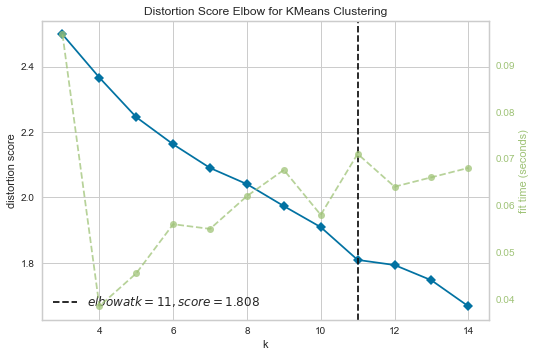

In [32]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(3,15))

visualizer.fit(venues_clustering)
visualizer.poof()

In [33]:
# Meilleur paramètre K
k_clusters = 11
# Exécuter l'algorithme de regroupement de K-Means
model = KMeans(n_clusters=k_clusters, random_state=0).fit(venues_clustering)
# Vérifiez les étiquettes de groupes générées pour chaque ligne du cadre de données
model.labels_[0:10]

array([1, 0, 2, 3, 1, 3, 7, 7, 7, 2])

In [34]:
# Ajouter des étiquettes de regroupement
venues_sorted.insert(0, 'Cluster Labels', model.labels_)

venues_merged = cities
# Fusionner les lieux_groupés avec le DF avec les codes postaux sélectionnés
# pour ajouter la latitude/longitude pour chaque groupe de quartier
venues_merged = venues_merged.join(venues_sorted.set_index('City Name'), on='City')

venues_merged.head()

,City,Country,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Hong Kong,22.279328,114.162813,7,Hotel,Shopping Mall,Italian Restaurant,Park,Japanese Restaurant,Bar,Gym / Fitness Center,Thai Restaurant,Coffee Shop,Café
1,Bangkok,Thailand,13.754253,100.493087,7,Hotel,Thai Restaurant,Noodle House,Coffee Shop,Park,Asian Restaurant,Bookstore,Bakery,Shopping Mall,Dessert Shop
2,London,United Kingdom,51.507322,-0.127647,7,Hotel,Park,Coffee Shop,Art Museum,Cocktail Bar,Lounge,Hotel Bar,Department Store,Theater,Bookstore
3,Macau,Macau,-5.113366,-36.634996,2,Pizza Place,Restaurant,Beach,BBQ Joint,Bakery,Acai House,Brazilian Restaurant,Plaza,Hotel,Snack Place
4,Singapore,Singapore,1.357107,103.819499,7,Hotel,Park,Japanese Restaurant,Garden,Scenic Lookout,Wine Bar,Cocktail Bar,Italian Restaurant,Ice Cream Shop,Clothing Store


Et enfin, nous pouvons visualiser les grappes qui en résultent :

In [35]:
# Créer une carte du Folium
map_clusters = folium.Map(location=[0, 0], zoom_start=1)

# Définir le schéma de couleurs pour les groupes
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Ajouter des marqueurs à la carte
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['City'], venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Section 6 : Analyse des groupements résultants
Comme l'a montré le graphique de la méthode du coude, il est assez difficile de définir le nombre de grappes que le modèle doit utiliser, car le coude n'était pas assez clair, et donc déterminer les caractéristiques exactes de chaque grappe peut être un peu flou. Quoi qu'il en soit, nous allons essayer de les déterminer.

Cluster 1 :

In [36]:
venues_merged.loc[venues_merged['Cluster Labels'] == 0, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]


,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Agra,India,Hotel,Indian Restaurant,Historic Site,Fast Food Restaurant,Multicuisine Indian Restaurant,Resort,Pizza Place,Coffee Shop,Border Crossing,Market
38,Jaipur,India,Hotel,Historic Site,Café,Palace,Resort,Indian Restaurant,Hostel,Bakery,Shopping Mall,Tea Room


Cluster 2:

In [37]:
venues_merged.loc[venues_merged['Cluster Labels'] == 1, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Denpasar,Indonesia,Hotel,Café,Indonesian Restaurant,Resort,Coffee Shop,Restaurant,Beach,Cocktail Bar,Asian Restaurant,Ice Cream Shop
41,Cairo,Egypt,Café,Hotel,Historic Site,Middle Eastern Restaurant,Italian Restaurant,Sports Club,Supermarket,Lebanese Restaurant,Dessert Shop,Coffee Shop
42,Athens,Greece,Café,Coffee Shop,Bar,Historic Site,Meze Restaurant,Greek Restaurant,Souvlaki Shop,History Museum,Park,Bookstore
55,Munich,Germany,Café,Hotel,Plaza,Cocktail Bar,Ice Cream Shop,German Restaurant,Gourmet Shop,Church,Coffee Shop,Beer Garden
60,Jerusalem,Israel,Hotel,Café,Historic Site,Middle Eastern Restaurant,Mountain,Park,History Museum,Mediterranean Restaurant,Scenic Lookout,Bar
64,Penang Island,Malaysia,Hotel,Café,Coffee Shop,Chinese Restaurant,Resort,Park,Japanese Restaurant,Vegetarian / Vegan Restaurant,Shopping Mall,Tea Room
67,Zhuhai,China,Café,Hotel,Coffee Shop,Resort,Portuguese Restaurant,Casino,Historic Site,Shopping Mall,Chinese Restaurant,Cantonese Restaurant
74,Marrakesh,Morocco,Moroccan Restaurant,Hotel,Resort,Café,Restaurant,Historic Site,Nightclub,French Restaurant,Museum,Bed & Breakfast
83,Muğla,Turkey,Café,Bar,Hotel,Pub,Coffee Shop,Beach,Turkish Restaurant,Gym,Restaurant,Gym / Fitness Center
86,Frankfurt am Main,Germany,Café,Park,Hotel,Supermarket,Pizza Place,Coffee Shop,Art Museum,Plaza,Opera House,German Restaurant


Cluster 3:

In [38]:
venues_merged.loc[venues_merged['Cluster Labels'] == 2, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Macau,Macau,Pizza Place,Restaurant,Beach,BBQ Joint,Bakery,Acai House,Brazilian Restaurant,Plaza,Hotel,Snack Place
24,Amsterdam,Netherlands,Hotel,Coffee Shop,Bar,Breakfast Spot,Cocktail Bar,Restaurant,Plaza,Café,Theater,Bakery
26,Miami,United States,Hotel,Beach,Park,Seafood Restaurant,Bakery,Mexican Restaurant,Grocery Store,Peruvian Restaurant,Gym / Fitness Center,Bar
28,Las Vegas,United States,Hotel,American Restaurant,Casino,Theater,Seafood Restaurant,Nightclub,Spa,Mexican Restaurant,Resort,Fast Food Restaurant
39,Cancún,Mexico,Resort,Mexican Restaurant,Taco Place,Beach,Seafood Restaurant,Italian Restaurant,Ice Cream Shop,Shopping Mall,Argentinian Restaurant,Hotel
65,Heraklion,Greece,Greek Restaurant,Bakery,Cretan Restaurant,Coffee Shop,Historic Site,Hotel,Plaza,Dessert Shop,Café,Supermarket
68,Vancouver,Canada,Hotel,Park,Coffee Shop,Bakery,Trail,Ice Cream Shop,Seafood Restaurant,Beach,Middle Eastern Restaurant,Café
76,Cebu City,Philippines,Shopping Mall,Coffee Shop,Hotel,Bakery,Resort,Restaurant,Seafood Restaurant,BBQ Joint,Italian Restaurant,Burger Joint
80,Honolulu,United States,Japanese Restaurant,Hotel,Hawaiian Restaurant,Beach,Cocktail Bar,Bakery,Coffee Shop,Seafood Restaurant,American Restaurant,Ice Cream Shop
84,Buenos Aires,Argentina,Ice Cream Shop,Hotel,Argentinian Restaurant,BBQ Joint,Plaza,Gym / Fitness Center,Bakery,Coffee Shop,Italian Restaurant,Pizza Place


Cluster 4:

In [39]:
venues_merged.loc[venues_merged['Cluster Labels'] == 3, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,New York City,United States,Park,Bookstore,Ice Cream Shop,Bakery,Scenic Lookout,Cycle Studio,Italian Restaurant,Indie Movie Theater,Furniture / Home Store,Movie Theater
11,Antalya,Turkey,Park,Restaurant,Café,Coffee Shop,Bar,Gym / Fitness Center,Pizza Place,Scenic Lookout,Seafood Restaurant,Hotel
21,Prague,Czech Republic,Café,Park,Coffee Shop,Cocktail Bar,Scenic Lookout,Hotel,Sushi Restaurant,Ice Cream Shop,Wine Bar,Indie Movie Theater
23,Seoul,South Korea,Park,BBQ Joint,Hotel,Coffee Shop,Bakery,Fried Chicken Joint,Art Museum,Trail,Korean Restaurant,Mountain
33,Los Angeles,United States,Coffee Shop,Trail,Italian Restaurant,Park,Sandwich Place,Pizza Place,Yoga Studio,Theater,Ice Cream Shop,Museum
40,Berlin,Germany,Coffee Shop,Park,Bookstore,Ice Cream Shop,Hotel,Café,Bar,Bakery,Concert Hall,Wine Bar
44,Moscow,Russia,Park,Gym / Fitness Center,Restaurant,Big Box Store,Yoga Studio,Sports Bar,Supermarket,Multiplex,Eastern European Restaurant,Brewery
49,Dublin,Ireland,Café,Coffee Shop,Pub,Park,Hotel,Burger Joint,Plaza,Beer Bar,Indie Movie Theater,Pizza Place
52,Toronto,Canada,Coffee Shop,Park,Bakery,Café,Hotel,Gym,Restaurant,Sandwich Place,Farmers Market,Historic Site
54,Sydney,Australia,Park,Café,Coffee Shop,Scenic Lookout,Theater,Ice Cream Shop,Bakery,Bookstore,Beach,Pizza Place


Cluster 5:

In [40]:
venues_merged.loc[venues_merged['Cluster Labels'] == 4, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Dubai,United Arab Emirates,Resort,Hotel,Beach,Café,Shopping Mall,Restaurant,American Restaurant,Lounge,Plaza,Pub
14,Phuket,Thailand,Resort,Thai Restaurant,Hotel,Restaurant,Coffee Shop,Spa,Ice Cream Shop,Café,Shopping Mall,Bakery
17,Pattaya,Thailand,Hotel,Thai Restaurant,Resort,Spa,Restaurant,Coffee Shop,Massage Studio,Noodle House,Café,Nightclub
47,Ha Long,Vietnam,Vietnamese Restaurant,Hotel,Cave,Resort,Bay,Beach,National Park,Cruise,Asian Restaurant,Farm
81,Hurghada,Egypt,Resort,Beach,Surf Spot,Restaurant,Seafood Restaurant,Hotel,Hotel Bar,Dive Spot,Nightclub,Lounge
98,Krabi,Thailand,Thai Restaurant,Resort,Noodle House,Coffee Shop,Hotel,Café,Seafood Restaurant,Hostel,Flea Market,Lake


Cluster 6:

In [41]:
venues_merged.loc[venues_merged['Cluster Labels'] == 5, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Mecca,Saudi Arabia,Coffee Shop,Hotel,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,Café,Fried Chicken Joint,Donut Shop,Burger Joint,Diner
30,Ho Chi Minh City,Vietnam,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Pizza Place,French Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Whisky Bar,Massage Studio
51,Hanoi,Vietnam,Coffee Shop,Hotel,Vietnamese Restaurant,Noodle House,Café,Pizza Place,Beer Bar,Park,Brewery,Burger Joint
89,Da Nang,Vietnam,Resort,Vietnamese Restaurant,Coffee Shop,Hotel,Beach,Mountain,Spa,Sandwich Place,Beach Bar,Bed & Breakfast


Main characteristics:

Cluster 7:

In [42]:
venues_merged.loc[venues_merged['Cluster Labels'] == 6, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Paris,France,Plaza,Hotel,Art Museum,French Restaurant,Bookstore,Garden,Historic Site,Cocktail Bar,Bakery,Art Gallery
15,Rome,Italy,Plaza,Historic Site,Church,Ice Cream Shop,Monument / Landmark,Italian Restaurant,Fountain,Hotel,Sandwich Place,Scenic Lookout
34,Milan,Italy,Park,Italian Restaurant,Hotel,Plaza,Pizza Place,Café,Monument / Landmark,Ice Cream Shop,Seafood Restaurant,Coffee Shop
36,Vienna,Austria,Austrian Restaurant,Hotel,Plaza,Art Museum,Park,Café,Bar,Restaurant,Breakfast Spot,French Restaurant
45,Venice,Italy,Italian Restaurant,Hotel,Pizza Place,Plaza,Wine Bar,Scenic Lookout,Ice Cream Shop,Beach,Historic Site,Cocktail Bar
46,Madrid,Spain,Plaza,Hotel,Spanish Restaurant,Restaurant,Tapas Restaurant,Monument / Landmark,Coffee Shop,Art Museum,Park,Garden
50,Florence,Italy,Italian Restaurant,Plaza,Ice Cream Shop,Hotel,Church,Art Museum,Sandwich Place,Boutique,Winery,Dessert Shop
62,Lisbon,Portugal,Plaza,Portuguese Restaurant,Scenic Lookout,Wine Bar,Ice Cream Shop,Café,Hostel,Hotel,Vegetarian / Vegan Restaurant,Restaurant
95,Porto,Portugal,Portuguese Restaurant,Garden,Hotel,Plaza,Tapas Restaurant,Scenic Lookout,Café,Wine Bar,Coffee Shop,Brewery


Cluster 8:

In [43]:
venues_merged.loc[venues_merged['Cluster Labels'] == 7, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Hong Kong,Hotel,Shopping Mall,Italian Restaurant,Park,Japanese Restaurant,Bar,Gym / Fitness Center,Thai Restaurant,Coffee Shop,Café
1,Bangkok,Thailand,Hotel,Thai Restaurant,Noodle House,Coffee Shop,Park,Asian Restaurant,Bookstore,Bakery,Shopping Mall,Dessert Shop
2,London,United Kingdom,Hotel,Park,Coffee Shop,Art Museum,Cocktail Bar,Lounge,Hotel Bar,Department Store,Theater,Bookstore
4,Singapore,Singapore,Hotel,Park,Japanese Restaurant,Garden,Scenic Lookout,Wine Bar,Cocktail Bar,Italian Restaurant,Ice Cream Shop,Clothing Store
8,Kuala Lumpur,Malaysia,Hotel,Shopping Mall,Ice Cream Shop,Spa,Grocery Store,Café,Asian Restaurant,Middle Eastern Restaurant,Convenience Store,Malay Restaurant
9,Istanbul,Turkey,Hotel,Historic Site,Waterfront,Soccer Stadium,Concert Hall,Coffee Shop,Park,Café,Art Museum,Nightclub
10,Delhi,India,Hotel,Indian Restaurant,Café,Restaurant,Italian Restaurant,Shopping Mall,Market,Monument / Landmark,Bakery,Lounge
13,Mumbai,India,Hotel,Scenic Lookout,Café,Indian Restaurant,Coffee Shop,Deli / Bodega,Seafood Restaurant,Lounge,Asian Restaurant,Cricket Ground
18,Taipei,Taiwan,Hotel,Dumpling Restaurant,Taiwanese Restaurant,Bakery,Dessert Shop,Bookstore,Park,Noodle House,Chinese Restaurant,Café
20,Guangzhou,China,Hotel,Coffee Shop,Shopping Mall,Park,Chinese Restaurant,Turkish Restaurant,Seafood Restaurant,Zoo Exhibit,Furniture / Home Store,Spa


Principales caractéristiques :

Cluster 9

In [44]:
venues_merged.loc[venues_merged['Cluster Labels'] == 8, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,Rhodes,Greece,Greek Restaurant,Beach,Hotel,Taverna,Resort,Café,Restaurant,Historic Site,Cocktail Bar,Fish Taverna


Principales caractéristiques :

Cluster 10:

In [45]:
venues_merged.loc[venues_merged['Cluster Labels'] == 9, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Shenzhen,China,Park,Theme Park Ride / Attraction,Shopping Mall,Hotel,Theme Park,Golf Course,Dessert Shop,Electronics Store,Mountain,Coffee Shop
16,Tokyo,Japan,Garden,Hotel,BBQ Joint,Chinese Restaurant,Art Museum,Japanese Restaurant,History Museum,Kaiseki Restaurant,Ramen Restaurant,Udon Restaurant
27,Osaka,Japan,Theme Park Ride / Attraction,Hotel,Ramen Restaurant,Japanese Curry Restaurant,Bar,Park,Japanese Restaurant,Coffee Shop,Sake Bar,Bakery
43,Orlando,United States,Theme Park Ride / Attraction,Park,Convenience Store,Grocery Store,Pizza Place,Theme Park,Wine Shop,Resort,Cuban Restaurant,Clothing Store
66,Kyoto,Japan,Buddhist Temple,Wagashi Place,Café,Coffee Shop,Sake Bar,Shrine,Japanese Restaurant,Historic Site,Bakery,Hotel
85,Chiba,Japan,Ramen Restaurant,Theme Park Ride / Attraction,Bakery,Park,Spa,Coffee Shop,Sake Bar,Hot Spring,Hotel,Restaurant
92,Fukuoka,Japan,Ramen Restaurant,Udon Restaurant,Café,Japanese Restaurant,Coffee Shop,Tempura Restaurant,Park,Nabe Restaurant,Bakery,Hotel


Principales caractéristiques :

Cluster 11

In [46]:
venues_merged.loc[venues_merged['Cluster Labels'] == 10, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Medina,Saudi Arabia,Coffee Shop,Café,Dessert Shop,Hotel,Breakfast Spot,Fried Chicken Joint,Bagel Shop,Juice Bar,Sandwich Place,Ice Cream Shop
48,Riyadh,Saudi Arabia,Coffee Shop,Supermarket,Jewelry Store,Gym / Fitness Center,Gym,Hotel,Café,Frozen Yogurt Shop,Ice Cream Shop,Plaza
61,Budapest,Hungary,Coffee Shop,Bar,Bakery,Hotel,Theater,Park,Pizza Place,Greek Restaurant,Dessert Shop,Hungarian Restaurant
63,Dammam,Saudi Arabia,Coffee Shop,Bakery,Supermarket,Juice Bar,Café,Park,Donut Shop,Hookah Bar,Plaza,Gym / Fitness Center
69,Chiang Mai,Thailand,Coffee Shop,Thai Restaurant,Hotel,Noodle House,Café,Juice Bar,Dessert Shop,Asian Restaurant,Buddhist Temple,Bed & Breakfast


Principales caractéristiques :